In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv
import dagshub
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import optuna
from optuna.samplers import TPESampler # bayesian optimizer for the selection of hyperparameters in optuna	
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix
import mlflow
from mlflow.models import infer_signature
import joblib

c:\Users\Yassine\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load environment variables from the .env file
load_dotenv("../.env")

# Set the DagsHub username and token from environment variables
dagshub_username = os.getenv('MLFLOW_TRACKING_USERNAME')
dagshub_token = os.getenv('MLFLOW_TRACKING_PASSWORD')

# Print or assert to confirm the values are loaded
if dagshub_username and dagshub_token:
    print("Environment variables loaded successfully:")
    print("DagsHub Username:", dagshub_username)
    print("DagsHub Token:", "Loaded" if dagshub_token else "Not Loaded")
else:
    print("Failed to load environment variables.")

# Set the MLflow tracking URI to your existing DagsHub repository
mlflow.set_tracking_uri(f"https://dagshub.com/yassine_msaddak/insurance-car-accident-fraud-detection.mlflow")

# Optionally authenticate with your DagsHub credentials
os.environ['MLFLOW_TRACKING_USERNAME'] = dagshub_username
os.environ['MLFLOW_TRACKING_PASSWORD'] = dagshub_token

# Now you can log your model and experiments directly with MLflow
print(f"Using MLflow to track experiments on DagsHub repo: {dagshub_username}/insurance-car-accident-fraud-detection")

Environment variables loaded successfully:
DagsHub Username: yassine_msaddak
DagsHub Token: Loaded
Using MLflow to track experiments on DagsHub repo: yassine_msaddak/insurance-car-accident-fraud-detection


In [3]:
train_path = os.path.join(os.path.dirname("modeling.ipynb"), '..', 'data', 'df_train_1.csv')
test_path = os.path.join(os.path.dirname("modeling.ipynb"), '..', 'data', 'df_test_1.csv')
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

X_train = train.drop(columns=['FraudFound_P'])
y_train = train['FraudFound_P']
X_test = test.drop(columns=['FraudFound_P'])
y_test = test['FraudFound_P']


# Define the paths to the train and test CSV files for unbalanced data
train_path_unbalanced = os.path.join(os.path.dirname("modeling.ipynb"), '..', 'data', 'df_train_1_unbalanced.csv')
test_path_unbalanced = os.path.join(os.path.dirname("modeling.ipynb"), '..', 'data', 'df_test_1_unbalanced.csv')

# Load the train and test datasets
train_unbalanced = pd.read_csv(train_path_unbalanced)
test_unbalanced = pd.read_csv(test_path_unbalanced)

# Prepare the feature matrices (X) and target vectors (y)
X_train_unbalanced = train_unbalanced.drop(columns=['FraudFound_P'])
y_train_unbalanced = train_unbalanced['FraudFound_P']
X_test_unbalanced = test_unbalanced.drop(columns=['FraudFound_P'])
y_test_unbalanced = test_unbalanced['FraudFound_P']

# Logistic Regression

In [4]:
# Create a new MLflow Experiment
mlflow.set_experiment("insurance-fraud-detection-experiment")

params = {'max_iter':1500, 'solver':'liblinear', 'class_weight':'balanced', 'penalty':'l2', 'C':1.0,}
# Initialize the Logistic Regression model with increased max_iter
log_reg = LogisticRegression(**params)

# Train the model
log_reg.fit(X_train, y_train)

# Make predictions on training data
y_train_pred = log_reg.predict(X_train)
y_train_pred_prob = log_reg.predict_proba(X_train)[:, 1]

# Make predictions on test data
y_test_pred = log_reg.predict(X_test)
y_test_pred_prob = log_reg.predict_proba(X_test)[:, 1]

# Evaluate the model on training data
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Evaluate the model on test data
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Metrics:")
print(f"F1 Score: {train_f1}")
print(f"ROC AUC Score: {train_roc_auc}")
print(f"Accuracy: {train_accuracy}")

print("\nTest Metrics:")
print(f"F1 Score: {test_f1}")
print(f"ROC AUC Score: {test_roc_auc}")
print(f"Accuracy: {test_accuracy}")

Training Metrics:
F1 Score: 0.8223158256683573
ROC AUC Score: 0.9016281750091026
Accuracy: 0.8217335058214748

Test Metrics:
F1 Score: 0.15121951219512195
ROC AUC Score: 0.6668837709499322
Accuracy: 0.77431906614786


In [ ]:
# Log parameters and metrics with MLflow
mlflow.log_params(params)
mlflow.log_metric("train_accuracy", train_accuracy)
mlflow.log_metric("train_F1_Score", train_f1)
mlflow.log_metric("train_ROC_AUC_Score", train_roc_auc)
mlflow.log_metric("test_accuracy", test_accuracy)
mlflow.log_metric("test_F1_Score", test_f1)
mlflow.log_metric("test_ROC_AUC_Score", test_roc_auc)

# Set a tag for the run
mlflow.set_tag("Training Info", "SVM model training")

# Infer the model signature
signature = infer_signature(X_train, svm_model.predict(X_train))

# Log the model
model_info = mlflow.sklearn.log_model(
    sk_model=log_reg,
    artifact_path="insurance_fraud_model_svm",
    signature=signature,
    input_example=X_train,
    registered_model_name="logistic_regression",
)

# SVM

In [5]:
# Create a new MLflow Experiment
mlflow.set_experiment("insurance-fraud-detection-experiment")

# Parameters for SVM
params = {
    'kernel': 'linear',
    'C':5.4,
    'max_iter': -1,
    'probability': True
}

# Initialize the SVM model with the specified parameters
svm_model = SVC(**params)

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions on training data
y_train_pred = svm_model.predict(X_train)
y_train_pred_prob = svm_model.predict_proba(X_train)[:, 1]

# Make predictions on test data
y_test_pred = svm_model.predict(X_test)
y_test_pred_prob = svm_model.predict_proba(X_test)[:, 1]

# Evaluate the model on training data
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Evaluate the model on test data
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Metrics:")
print(f"F1 Score: {train_f1}")
print(f"ROC AUC Score: {train_roc_auc}")
print(f"Accuracy: {train_accuracy}")

print("\nTest Metrics:")
print(f"F1 Score: {test_f1}")
print(f"ROC AUC Score: {test_roc_auc}")
print(f"Accuracy: {test_accuracy}")

Training Metrics:
F1 Score: 0.8291204986149584
ROC AUC Score: 0.9025885449545903
Accuracy: 0.8297542043984476

Test Metrics:
F1 Score: 0.13648293963254593
ROC AUC Score: 0.6624457554850387
Accuracy: 0.7866407263294423


In [ ]:
# Log parameters and metrics with MLflow
mlflow.log_params(params)
mlflow.log_metric("train_accuracy", train_accuracy)
mlflow.log_metric("train_F1_Score", train_f1)
mlflow.log_metric("train_ROC_AUC_Score", train_roc_auc)
mlflow.log_metric("test_accuracy", test_accuracy)
mlflow.log_metric("test_F1_Score", test_f1)
mlflow.log_metric("test_ROC_AUC_Score", test_roc_auc)

# Set a tag for the run
mlflow.set_tag("Training Info", "SVM model training")

# Infer the model signature
signature = infer_signature(X_train, svm_model.predict(X_train))

# Log the model
model_info = mlflow.sklearn.log_model(
    sk_model=svm_model,
    artifact_path="insurance_fraud_model_svm",
    signature=signature,
    input_example=X_train,
    registered_model_name="SVM_v2",
)

# KNN

In [8]:
# Create a new MLflow Experiment
mlflow.set_experiment("insurance-fraud-detection-experiment")

# Parameters for KNN
params = {
    'n_neighbors': 2,
    'p': 3
}

# Initialize the KNN model with the specified parameters
knn_model = KNeighborsClassifier(**params)

# Train the model
knn_model.fit(X_train, y_train)

# Make predictions on training data
y_train_pred = knn_model.predict(X_train)
y_train_pred_prob = knn_model.predict_proba(X_train)[:, 1]

# Make predictions on test data
y_test_pred = knn_model.predict(X_test)
y_test_pred_prob = knn_model.predict_proba(X_test)[:, 1]

# Evaluate the model on training data
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Evaluate the model on test data
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Metrics:")
print(f"F1 Score: {train_f1}")
print(f"ROC AUC Score: {train_roc_auc}")
print(f"Accuracy: {train_accuracy}")

print("\nTest Metrics:")
print(f"F1 Score: {test_f1}")
print(f"ROC AUC Score: {test_roc_auc}")
print(f"Accuracy: {test_accuracy}")

Training Metrics:
F1 Score: 0.9947979885555748
ROC AUC Score: 0.9988485914405537
Accuracy: 0.9948253557567918

Test Metrics:
F1 Score: 0.12041884816753927
ROC AUC Score: 0.5606819094069265
Accuracy: 0.7821011673151751


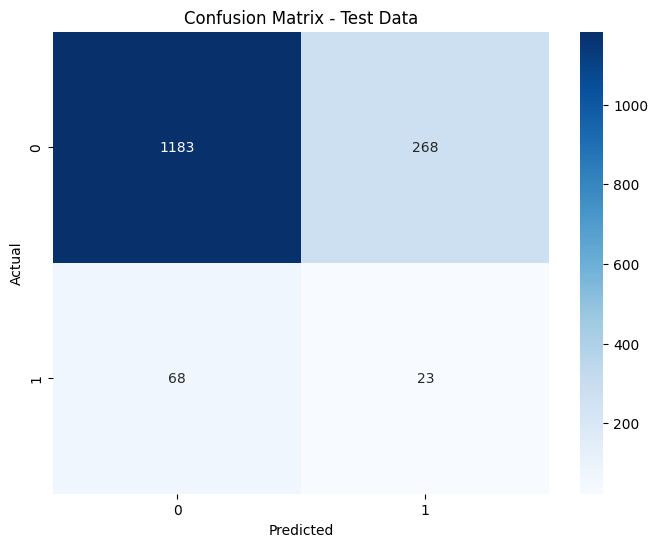

In [9]:
# Plot confusion matrix for test data
train_cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Log parameters and metrics with MLflow
mlflow.log_params(params)
mlflow.log_metric("train_accuracy", train_accuracy)
mlflow.log_metric("train_F1_Score", train_f1)
mlflow.log_metric("train_ROC_AUC_Score", train_roc_auc)
mlflow.log_metric("test_accuracy", test_accuracy)
mlflow.log_metric("test_F1_Score", test_f1)
mlflow.log_metric("test_ROC_AUC_Score", test_roc_auc)

# Set a tag for the run
mlflow.set_tag("Training Info", "KNN model training")

# Infer the model signature
signature = infer_signature(X_train, knn_model.predict(X_train))

# Log the model
model_info = mlflow.sklearn.log_model(
    sk_model=knn_model,
    artifact_path="insurance_fraud_model_knn",
    signature=signature,
    input_example=X_train,
    registered_model_name="KNN_v2",
)

# Random Forest

In [10]:
# Create a new MLflow Experiment
mlflow.set_experiment("insurance-fraud-detection-experiment")

# Parameters for Random Forest
params = {
    'n_estimators': 700,  # Number of trees in the forest
    'min_samples_split': 2,  # Minimum number of samples required to split an internal node
    'min_samples_leaf': 1,  # Minimum number of samples required to be at a leaf node
}

# Initialize the Random Forest model with the specified parameters
rf_model = RandomForestClassifier(**params)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on test data
y_test_pred = rf_model.predict(X_test)
y_test_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model on training data
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Evaluate the model on test data
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Metrics:")
print(f"F1 Score: {train_f1}")
print(f"ROC AUC Score: {train_roc_auc}")
print(f"Accuracy: {train_accuracy}")

print("\nTest Metrics:")
print(f"F1 Score: {test_f1}")
print(f"ROC AUC Score: {test_roc_auc}")
print(f"Accuracy: {test_accuracy}")

Training Metrics:
F1 Score: 0.9947979885555748
ROC AUC Score: 0.9988485914405537
Accuracy: 0.9948253557567918

Test Metrics:
F1 Score: 0.14492753623188406
ROC AUC Score: 0.7469157307200037
Accuracy: 0.8852140077821011


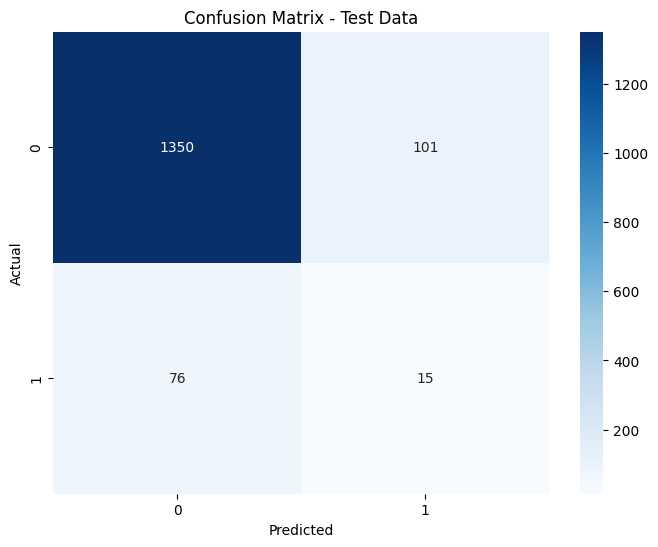

In [11]:
# Plot confusion matrix for test data
train_cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Log parameters and metrics with MLflow
mlflow.log_params(params)
mlflow.log_metric("train_accuracy", train_accuracy)
mlflow.log_metric("train_F1_Score", train_f1)
mlflow.log_metric("train_ROC_AUC_Score", train_roc_auc)
mlflow.log_metric("test_accuracy", test_accuracy)
mlflow.log_metric("test_F1_Score", test_f1)
mlflow.log_metric("test_ROC_AUC_Score", test_roc_auc)

# Set a tag for the run
mlflow.set_tag("Training Info", "Random Forest model training")

# Infer the model signature
signature = infer_signature(X_train, rf_model.predict(X_train))

# Log the model
model_info = mlflow.sklearn.log_model(
    sk_model=rf_model,
    artifact_path="insurance_fraud_model_rf",
    signature=signature,
    input_example=X_train,
    registered_model_name="RandomForest_v1",
)

# Lightgbm

In [12]:
# Create a new MLflow Experiment
mlflow.set_experiment("insurance-fraud-detection-experiment")
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 33,
    'learning_rate': 0.01,
    'n_estimators': 146
}

# Initialize the LightGBM model with the specified parameters
lgb_model = lgb.LGBMClassifier(**params)

# Train the model
lgb_model.fit(X_train, y_train)

# Make predictions on training data
y_train_pred = lgb_model.predict(X_train)
y_train_pred_prob = lgb_model.predict_proba(X_train)[:, 1]

# Make predictions on test data
y_test_pred = lgb_model.predict(X_test)
y_test_pred_prob = lgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model on training data
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Evaluate the model on test data
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Metrics:")
print(f"F1 Score: {train_f1}")
print(f"ROC AUC Score: {train_roc_auc}")
print(f"Accuracy: {train_accuracy}")

print("\nTest Metrics:")
print(f"F1 Score: {test_f1}")
print(f"ROC AUC Score: {test_roc_auc}")
print(f"Accuracy: {test_accuracy}")

[LightGBM] [Info] Number of positive: 5797, number of negative: 5798
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 159
[LightGBM] [Info] Number of data points in the train set: 11595, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499957 -> initscore=-0.000172
[LightGBM] [Info] Start training from score -0.000172
Training Metrics:
F1 Score: 0.8743063507442966
ROC AUC Score: 0.9524928679611674
Accuracy: 0.8769297110823631

Test Metrics:
F1 Score: 0.1773049645390071
ROC AUC Score: 0.745366969350429
Accuracy: 0.8495460440985733


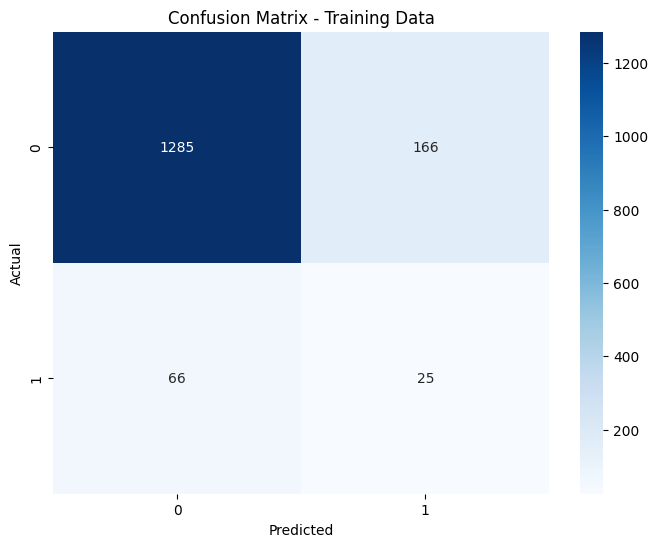

In [14]:
# Plot confusion matrix for test data
train_cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Training Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Lightgbm on unbalanced data

In [15]:
# Create a new MLflow Experiment
mlflow.set_experiment("insurance-fraud-detection-experiment")

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 32,
    'learning_rate': 0.01,
    'n_estimators': 150
}

# Initialize the LightGBM model with the specified parameters
lgb_model = lgb.LGBMClassifier(**params)

# Train the model
lgb_model.fit(X_train_unbalanced, y_train_unbalanced)

# Make predictions on training data
y_train_pred = lgb_model.predict(X_train_unbalanced)
y_train_pred_prob = lgb_model.predict_proba(X_train_unbalanced)[:, 1]

# Make predictions on test data
y_test_pred = lgb_model.predict(X_test_unbalanced)
y_test_pred_prob = lgb_model.predict_proba(X_test_unbalanced)[:, 1]

# Evaluate the model on training data
train_f1 = f1_score(y_train_unbalanced, y_train_pred)
train_roc_auc = roc_auc_score(y_train_unbalanced, y_train_pred_prob)
train_accuracy = accuracy_score(y_train_unbalanced, y_train_pred)

# Evaluate the model on test data
test_f1 = f1_score(y_test_unbalanced, y_test_pred)
test_roc_auc = roc_auc_score(y_test_unbalanced, y_test_pred_prob)
test_accuracy = accuracy_score(y_test_unbalanced, y_test_pred)

print("Training Metrics:")
print(f"F1 Score: {train_f1}")
print(f"ROC AUC Score: {train_roc_auc}")
print(f"Accuracy: {train_accuracy}")

print("\nTest Metrics:")
print(f"F1 Score: {test_f1}")
print(f"ROC AUC Score: {test_roc_auc}")
print(f"Accuracy: {test_accuracy}")

[LightGBM] [Info] Number of positive: 370, number of negative: 5798
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 156
[LightGBM] [Info] Number of data points in the train set: 6168, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.059987 -> initscore=-2.751765
[LightGBM] [Info] Start training from score -2.751765
Training Metrics:
F1 Score: 0.06266318537859007
ROC AUC Score: 0.9394495305930284
Accuracy: 0.9417963683527886

Test Metrics:
F1 Score: 0.021739130434782608
ROC AUC Score: 0.8212941434857356
Accuracy: 0.9416342412451362


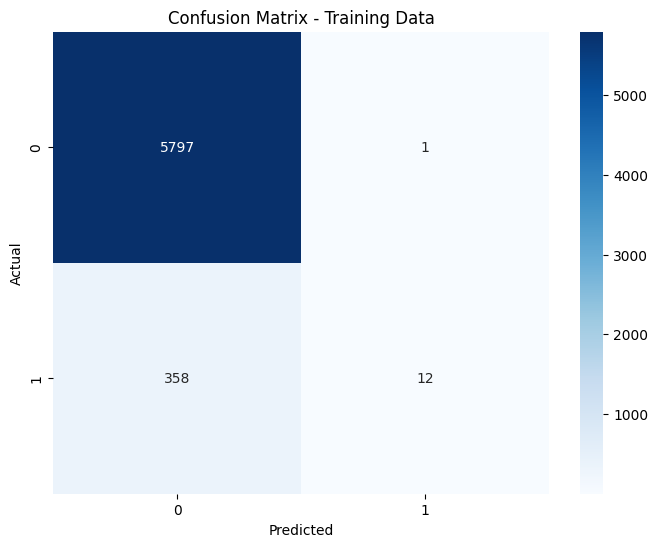

In [16]:
# Plot confusion matrix for training data
train_cm = confusion_matrix(y_train_unbalanced, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Training Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [63]:
# Log parameters and metrics with MLflow
mlflow.log_params(params)
mlflow.log_metric("train_accuracy", train_accuracy)
mlflow.log_metric("train_F1 Score", train_f1)
mlflow.log_metric("train_ROC AUC Score", train_roc_auc)
mlflow.log_metric("test_accuracy", test_accuracy)
mlflow.log_metric("test_F1 Score", test_f1)
mlflow.log_metric("test_ROC AUC Score", test_roc_auc)

# Set a tag for the run
mlflow.set_tag("Training Info", "LightGBM model training")

# Infer the model signature
signature = infer_signature(X_train, lgb_model.predict(X_train))

# Log the model
model_info = mlflow.lightgbm.log_model(
    lgb_model,
    artifact_path="insurance_fraud_model_lgb",
    signature=signature,
    input_example=X_train,
    registered_model_name="LightGBM_v4",
)

c:\Users\Yassine\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'LightGBM_v4'.
2024/11/16 11:31:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM_v4, version 1


# XGBoost on balanced data

In [17]:
# Parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 100,
}

# Initialize the XGBoost model with the specified parameters
xgb_model = xgb.XGBClassifier(**params)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on training data
y_train_pred = xgb_model.predict(X_train)
y_train_pred_prob = xgb_model.predict_proba(X_train)[:, 1]

# Make predictions on test data
y_test_pred = xgb_model.predict(X_test)
y_test_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model on training data
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Evaluate the model on test data
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Metrics:")
print(f"F1 Score: {train_f1}")
print(f"ROC AUC Score: {train_roc_auc}")
print(f"Accuracy: {train_accuracy}")

print("\nTest Metrics:")
print(f"F1 Score: {test_f1}")
print(f"ROC AUC Score: {test_roc_auc}")
print(f"Accuracy: {test_accuracy}")

Training Metrics:
F1 Score: 0.9131463332206826
ROC AUC Score: 0.9699593787820573
Accuracy: 0.9113410952996982

Test Metrics:
F1 Score: 0.16718266253869968
ROC AUC Score: 0.7518800978483955
Accuracy: 0.8255512321660181


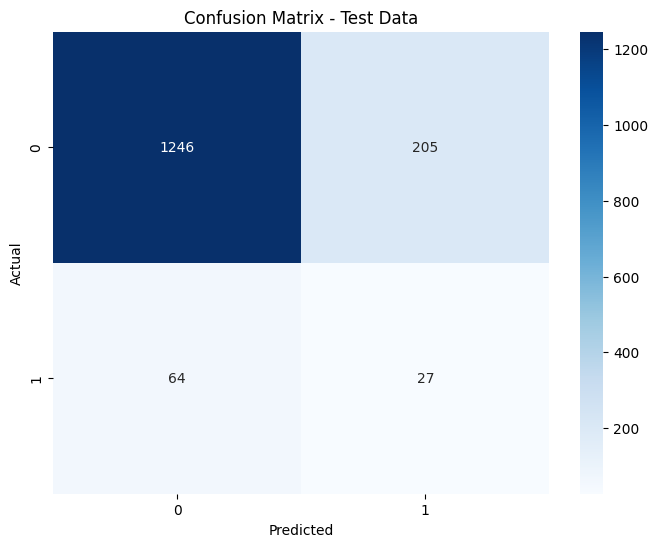

In [18]:
# Plot confusion matrix for test data
train_cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Modeling with Optuna
 - Optuna is an advanced hyperparameter optimization framework designed to streamline the tuning process in machine learning. It employs a Bayesian optimization approach, focusing on efficiency and automation by sampling hyperparameters intelligently based on past results. Unlike traditional methods like GridSearch, which exhaustively evaluates all parameter combinations, Optuna uses a more flexible and adaptive approach with its define-by-run API. This allows it to explore the hyperparameter space dynamically, saving computation time and resources. Additionally, Optuna supports pruning, which terminates underperforming trials early to focus on promising ones. While GridSearch is simple and systematic, making it easier to implement for smaller datasets or straightforward models, Optuna is more suitable for complex problems with large search spaces, where efficiency and scalability are crucial.

## Optuna framework on unbalanced data with boosting models

In [24]:
def objective(trial):
    classifier_name = trial.suggest_categorical('classifier', ['XGBoost', 'LightGBM', 'CatBoost'])
    
    if classifier_name == 'XGBoost':
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        n_estimators = trial.suggest_int('n_estimators', 25, 200)
        classifier_obj = xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            learning_rate=learning_rate,
            max_depth=max_depth,
            n_estimators=n_estimators)
    
    elif classifier_name == 'LightGBM':
        num_leaves = trial.suggest_int('lgb_num_leaves', 20, 70)
        learning_rate = trial.suggest_float('lgb_learning_rate', 0.01, 0.3)
        n_estimators = trial.suggest_int('lgb_n_estimators', 25, 200)
        classifier_obj = lgb.LGBMClassifier(num_leaves=num_leaves, n_estimators=n_estimators, verbose=-1)
    
    elif classifier_name == 'CatBoost':
        iterations = trial.suggest_int('cat_iterations', 50, 300)
        learning_rate = trial.suggest_float('cat_learning_rate', 0.01, 0.3)
        depth = trial.suggest_int('cat_depth', 2, 15)
        classifier_obj = CatBoostClassifier(iterations=iterations, depth=depth, verbose=0)
    
    classifier_obj.fit(X_train_unbalanced, y_train_unbalanced)
    y_prob = classifier_obj.predict_proba(X_test_unbalanced)[:, 1]
    
    # Threshold optimization
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_threshold = 0.5
    best_score = 0.0
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        score = f1_score(y_test_unbalanced, y_pred)
        if score > best_score:
            best_score = score
            best_threshold = threshold
    
    trial.set_user_attr('best_threshold', best_threshold)
    trial.set_user_attr('classifier_obj', classifier_obj)
    return roc_auc_score(y_test, (y_prob >= best_threshold).astype(int))

In [25]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=70)

[I 2024-11-22 23:48:51,857] A new study created in memory with name: no-name-97792bef-e445-408a-85de-56dc96278694
[I 2024-11-22 23:48:52,728] Trial 0 finished with value: 0.6028847100521807 and parameters: {'classifier': 'LightGBM', 'lgb_num_leaves': 39, 'lgb_learning_rate': 0.013227431749560177, 'lgb_n_estimators': 183}. Best is trial 0 with value: 0.6028847100521807.
[I 2024-11-22 23:48:53,467] Trial 1 finished with value: 0.6084170825728371 and parameters: {'classifier': 'XGBoost', 'learning_rate': 0.15539509973690707, 'max_depth': 10, 'n_estimators': 152}. Best is trial 1 with value: 0.6084170825728371.
[I 2024-11-22 23:48:54,206] Trial 2 finished with value: 0.5782446361357457 and parameters: {'classifier': 'LightGBM', 'lgb_num_leaves': 44, 'lgb_learning_rate': 0.09821751757857755, 'lgb_n_estimators': 197}. Best is trial 1 with value: 0.6084170825728371.
[I 2024-11-22 23:48:55,046] Trial 3 finished with value: 0.575832506569929 and parameters: {'classifier': 'LightGBM', 'lgb_num_l

In [27]:
best_trial = study.best_trial
print('Best trial: ', best_trial.values)
print('Best hyperparameters: ', best_trial.params)

Best trial:  [0.7530766958747661]
Best hyperparameters:  {'classifier': 'XGBoost', 'learning_rate': 0.05578888950793298, 'max_depth': 3, 'n_estimators': 112}


In [28]:
# Create a new MLflow Experiment
mlflow.set_experiment("insurance-fraud-detection-experiment")

# Parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': 0.05578888950793298,
    'max_depth': 3,
    'n_estimators': 112,
}

# Initialize the XGBoost model with the specified parameters
xgb_model = xgb.XGBClassifier(**params)

# Train the model
xgb_model.fit(X_train_unbalanced, y_train_unbalanced)

# Make predictions on training data
y_train_pred = xgb_model.predict(X_train_unbalanced)
y_train_pred_prob = xgb_model.predict_proba(X_train_unbalanced)[:, 1]

# Make predictions on test data
y_test_pred = xgb_model.predict(X_test_unbalanced)
y_test_pred_prob = xgb_model.predict_proba(X_test_unbalanced)[:, 1]

# Evaluate the model on training data
train_f1 = f1_score(y_train_unbalanced, y_train_pred)
train_roc_auc = roc_auc_score(y_train_unbalanced, y_train_pred_prob)
train_accuracy = accuracy_score(y_train_unbalanced, y_train_pred)

# Evaluate the model on test data
test_f1 = f1_score(y_test_unbalanced, y_test_pred)
test_roc_auc = roc_auc_score(y_test_unbalanced, y_test_pred_prob)
test_accuracy = accuracy_score(y_test_unbalanced, y_test_pred)

print("Training Metrics:")
print(f"F1 Score: {train_f1}")
print(f"ROC AUC Score: {train_roc_auc}")
print(f"Accuracy: {train_accuracy}")

print("\nTest Metrics:")
print(f"F1 Score: {test_f1}")
print(f"ROC AUC Score: {test_roc_auc}")
print(f"Accuracy: {test_accuracy}")

Training Metrics:
F1 Score: 0.082687338501292
ROC AUC Score: 0.8558988187911953
Accuracy: 0.9424448767833982

Test Metrics:
F1 Score: 0.021739130434782608
ROC AUC Score: 0.8342257329162913
Accuracy: 0.9416342412451362


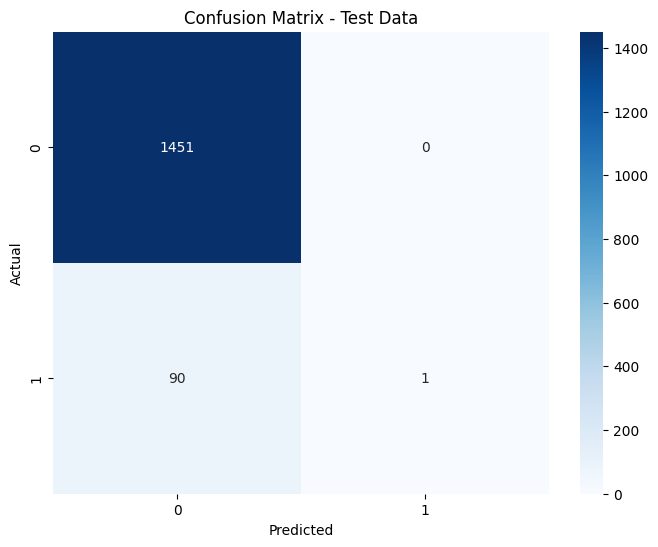

In [29]:
# Plot confusion matrix for test data
train_cm = confusion_matrix(y_test_unbalanced, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Optuna with balanced data on boosting models

In [30]:
def objective(trial):
    classifier_name = trial.suggest_categorical('classifier', ['XGBoost', 'LightGBM', 'CatBoost'])
    
    if classifier_name == 'XGBoost':
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        max_depth = trial.suggest_int('max_depth', 3, 40)
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        classifier_obj = xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            learning_rate=learning_rate,
            max_depth=max_depth,
            n_estimators=n_estimators,
            random_state=42
        )
    
    elif classifier_name == 'LightGBM':
        num_leaves = trial.suggest_int('lgb_num_leaves', 20, 70)
        learning_rate = trial.suggest_float('lgb_learning_rate', 0.01, 0.3)
        n_estimators = trial.suggest_int('lgb_n_estimators', 50, 300)
        classifier_obj = lgb.LGBMClassifier(num_leaves=num_leaves, n_estimators=n_estimators, verbose=-1)
    
    elif classifier_name == 'CatBoost':
        iterations = trial.suggest_int('cat_iterations', 20, 300)
        learning_rate = trial.suggest_float('cat_learning_rate', 0.01, 0.3)
        depth = trial.suggest_int('cat_depth', 3, 15)
        classifier_obj = CatBoostClassifier(iterations=iterations, depth=depth, verbose=0)
    
    classifier_obj.fit(X_train, y_train)
    y_prob = classifier_obj.predict_proba(X_test)[:, 1]
    
    # Threshold optimization
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_threshold = 0.5
    best_score = 0.0
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        score = f1_score(y_test, y_pred)
        if score > best_score:
            best_score = score
            best_threshold = threshold
    
    trial.set_user_attr('best_threshold', best_threshold)
    trial.set_user_attr('classifier_obj', classifier_obj)
    return roc_auc_score(y_test, (y_prob >= best_threshold).astype(int))

In [31]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=100)

[I 2024-11-22 23:53:51,837] A new study created in memory with name: no-name-d34d3173-a54b-497c-8f37-9a729969f08c
[I 2024-11-22 23:54:04,304] Trial 0 finished with value: 0.6160775819631782 and parameters: {'classifier': 'CatBoost', 'cat_iterations': 250, 'cat_learning_rate': 0.22870863162340183, 'cat_depth': 10}. Best is trial 0 with value: 0.6160775819631782.
[I 2024-11-22 23:54:05,046] Trial 1 finished with value: 0.7091623056474883 and parameters: {'classifier': 'XGBoost', 'learning_rate': 0.04313334960124037, 'max_depth': 5, 'n_estimators': 180}. Best is trial 1 with value: 0.7091623056474883.
[I 2024-11-22 23:54:06,540] Trial 2 finished with value: 0.6295165895441568 and parameters: {'classifier': 'XGBoost', 'learning_rate': 0.2871885810292479, 'max_depth': 25, 'n_estimators': 93}. Best is trial 1 with value: 0.7091623056474883.
[I 2024-11-22 23:54:08,205] Trial 3 finished with value: 0.6209018410948115 and parameters: {'classifier': 'XGBoost', 'learning_rate': 0.1100060798329508

In [32]:
best_trial = study.best_trial
print('Best trial: ', best_trial.values)
print('Best hyperparameters: ', best_trial.params)

Best trial:  [0.7372672124567368]
Best hyperparameters:  {'classifier': 'LightGBM', 'lgb_num_leaves': 52, 'lgb_learning_rate': 0.14704914491463633, 'lgb_n_estimators': 50}


In [4]:
# Create a new MLflow Experiment
mlflow.set_experiment("insurance-fraud-detection-experiment")

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 52,
    'learning_rate': 0.0147,
    'n_estimators': 50
}

# Initialize the LightGBM model with the specified parameters
lgb_model = lgb.LGBMClassifier(**params)

# Train the model
lgb_model.fit(X_train, y_train)

# Make predictions on training data
y_train_pred = lgb_model.predict(X_train)
y_train_pred_prob = lgb_model.predict_proba(X_train)[:, 1]

# Make predictions on test data
y_test_pred = lgb_model.predict(X_test)
y_test_pred_prob = lgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model on training data
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Evaluate the model on test data
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Metrics:")
print(f"F1 Score: {train_f1}")
print(f"ROC AUC Score: {train_roc_auc}")
print(f"Accuracy: {train_accuracy}")

print("\nTest Metrics:")
print(f"F1 Score: {test_f1}")
print(f"ROC AUC Score: {test_roc_auc}")
print(f"Accuracy: {test_accuracy}")

[LightGBM] [Info] Number of positive: 5797, number of negative: 5798
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 159
[LightGBM] [Info] Number of data points in the train set: 11595, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499957 -> initscore=-0.000172
[LightGBM] [Info] Start training from score -0.000172
Training Metrics:
F1 Score: 0.8774973711882229
ROC AUC Score: 0.9496362143995334
Accuracy: 0.8794307891332471

Test Metrics:
F1 Score: 0.1806020066889632
ROC AUC Score: 0.7274823728993267
Accuracy: 0.8411154345006485


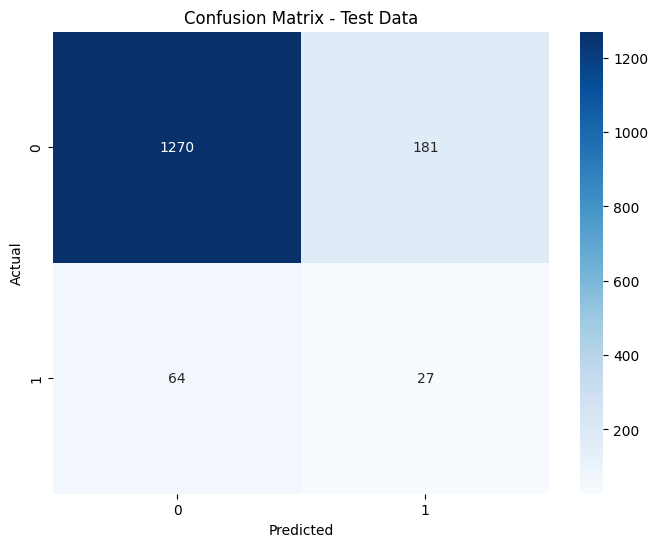

In [5]:
# Plot confusion matrix for test data
train_cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [6]:
# Log parameters and metrics with MLflow
mlflow.log_params(params)
mlflow.log_metric("train_accuracy", train_accuracy)
mlflow.log_metric("train_F1 Score", train_f1)
mlflow.log_metric("train_ROC AUC Score", train_roc_auc)
mlflow.log_metric("test_accuracy", test_accuracy)
mlflow.log_metric("test_F1 Score", test_f1)
mlflow.log_metric("test_ROC AUC Score", test_roc_auc)

# Set a tag for the run
mlflow.set_tag("Training Info", "LightGBM model training")

# Infer the model signature
signature = infer_signature(X_train, lgb_model.predict(X_train))

# Log the model
model_info = mlflow.lightgbm.log_model(
    lgb_model,
    artifact_path="insurance_fraud_model_lgb",
    signature=signature,
    input_example=X_train,
    registered_model_name="LightGBM_optuna",
)

c:\Users\Yassine\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LightGBM_optuna' already exists. Creating a new version of this model...
2024/11/23 00:11:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish

In [7]:
joblib.dump(lgb_model, 'model.pkl')

['model.pkl']

In [13]:
y_train.iloc[5]

0